<a href="https://colab.research.google.com/github/StanleyLiangYork/GAN_for_Medical_Image/blob/main/CVA_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons
!pip install -q tensorflow-probability

# to generate gifs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [8]:
from IPython import display
from IPython.display import clear_output
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras import layers
import shutil
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from PIL import Image
from matplotlib import pyplot as plt
import re

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

AUTOTUNE = tf.data.AUTOTUNE
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.8.2


In [9]:
tf.random.set_seed(100)

Fetch the COVID-19 data

In [6]:
if not os.path.exists('covid_set.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/covid_set.zip ./covid_set.zip

with ZipFile('covid_set.zip') as ZipObj:
  ZipObj.extractall()

Set up the folder for experiment

In [10]:
root_dir = '/content/covid_set'
paths = os.listdir(root_dir)

covid = re.compile("COVID")
normal = re.compile("NORMAL")
viral = re.compile("Viral")

covid_path = []
normal_path = []
viral_path = []

In [11]:
for path in paths:
  if covid.match(path):
    covid_path.append(path)
  if normal.match(path):
    normal_path.append(path)
  if viral.match(path):
    viral_path.append(path)


val_covid_path = covid_path[:50]
covid_path = covid_path[50:]
print(len(val_covid_path))
print(len(covid_path))

50
169


Build a balanced dataset, each class has 1014 images respectively <p>

In [12]:
for _ in range(5):
  random_items = random.sample(covid_path, 169)
  covid_path += random_items

print(len(covid_path))

1014


In [13]:
for i, path in enumerate(covid_path):
  covid_path[i] = root_dir + '/' + path

for i, path in enumerate(normal_path):
  normal_path[i] = root_dir + '/' + path

for i, path in enumerate(viral_path):
  viral_path[i] = root_dir + '/' + path


# 1014 + 50 = 1064 -- need 50 extra images from normal and from viral classes for the validation dataset
covid_path = covid_path
normal_path = normal_path[:1064]
viral_path = viral_path[:1064]

print(len(covid_path))
print(len(normal_path))
print(len(viral_path))

1014
1064
1064


In [14]:
# Run this to reset the VAE run
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [128, 128])


def get_label(file_path):
  if tf.strings.regex_full_match(file_path, ".*COVID.*"):
    return tf.constant(0.0, dtype="float32")
  elif tf.strings.regex_full_match(file_path, ".*NORMAL.*"):
    return tf.constant(1.0, dtype="float32")
  else:
    return tf.constant(2.0, dtype="float32")

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  # rescale from (0,255) to (0,1)
  img = (img - 127.5) / 127.5
  return img, label


def CVA_process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = img / 255.0
  return img, label

In [15]:
covid_ds = tf.data.Dataset.list_files(covid_path, shuffle=True)
normal_ds = tf.data.Dataset.list_files(normal_path[:1014], shuffle=True)
viral_ds = tf.data.Dataset.list_files(viral_path[:1014], shuffle=True)

BATCH_SIZE = 64
BUFFER_SIZE = 1014

covid_ds = covid_ds.map(CVA_process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
normal_ds = normal_ds.map(CVA_process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
viral_ds = viral_ds.map(CVA_process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
# VAE cost function as negative ELBO (Evidence Lower Bound Objective)

def normal_log_pdf(sample, mean, sd, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  logvar = np.log((np.square(sd)))
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def vae_cost(x_true, model, analytic_kl=True, kl_weight=0.01):
  z_sample, mu, sd = model.encode(x_true)
  x_recons_logits = model.decoder(z_sample)
  # compute cross entropy loss for each dimension of every datapoint
  raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits) # bs*128*128*3
  # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,), the first term of the objective
  neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3]) # the first term of the objective

  # compute reverse KL divergence, either analytically or through MC approximation with one sample, the second term of the objective
  if analytic_kl:
    kl_divergence = - 0.5 * tf.math.reduce_sum(1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd), axis=1)  # shape=(batch_size, )
  else:
    logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
    logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
    kl_divergence = logqz_x - logpz
  elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  # shape=()
  return -elbo

In [17]:
# Adjust the KL divergence weight here
def train_step(x_true, model, optimizer, analytic_kl=True, kl_weight=0.01):
  with tf.GradientTape() as tape:
    cost_mini_batch = vae_cost(x_true, model, analytic_kl, kl_weight)
  gradients = tape.gradient(cost_mini_batch, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return cost_mini_batch

In [19]:
class Encoder_Z(tfk.layers.Layer):

    def __init__(self, dim_z, name="encoder", **kwargs):
        super(Encoder_Z, self).__init__(name=name, **kwargs)
        self.dim_x = (128, 128, 3)
        self.dim_z = dim_z

    def build(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_x)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=4, strides=(2, 2), padding='same')) # 64*64*32
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=64, kernel_size=4, strides=(2, 2), padding='same')) # 32*32*64
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=128, kernel_size=4, strides=(2, 2), padding='same')) # 16*16*128
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=256, kernel_size=4, strides=(2, 2), padding='same')) # 8*8*256
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2D(filters=512, kernel_size=4, strides=(2, 2), padding='same')) # 4*4*512
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Flatten())
        layers.append(tfkl.Dense(self.dim_z * 2,
                                 activation=None))  # *2 because number of parameters for both mean and (raw) standard deviation
        return tfk.Sequential(layers)

In [20]:
class Decoder_X(tfk.layers.Layer):

    def __init__(self, dim_z, name="decoder", **kwargs):
        super(Decoder_X, self).__init__(name=name, **kwargs)
        self.dim_z = dim_z

    def build(self):
        layers = [tfkl.InputLayer(input_shape=(self.dim_z,))]
        layers.append(tfkl.Dense(4 * 4 * 16, activation=None))
        layers.append(tfkl.Reshape((4, 4, 16)))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same')) # 8*8*32
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')) # 16*16*64
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')) # 32*32*128
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same')) # 64*64*256
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='same')) # 128*128*512
        layers.append(tfkl.LeakyReLU())
        layers.append(tfkl.Conv2DTranspose(filters=3, kernel_size=4, strides=1, padding='same'))

        return tfk.Sequential(layers)

In [21]:
class VAE(tfk.Model):

    def __init__(self, dim_z, learning_rate, seed=2000, name="autoencoder", **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.dim_x = (128, 128, 3)
        self.dim_z = dim_z
        self.learning_rate = learning_rate
        self.seed = seed
        self.encoder = Encoder_Z(dim_z=self.dim_z).build()
        self.decoder = Decoder_X(dim_z=self.dim_z).build()

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.dim_z))
      return self.decode(eps, apply_sigmoid=True)


    def encode(self, x_input):
        mu, rho = tf.split(self.encoder(x_input), num_or_size_splits=2, axis=1)
        sd = tf.math.log(1 + tf.math.exp(rho))
        z_sample = mu + sd * tf.random.normal(shape=(self.dim_z,))
        return z_sample, mu, sd

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
          return probs
        return logits

In [22]:
autoencoder = VAE(128, 2e-4)
optimizer = tf.keras.optimizers.Adam(2e-4)

In [23]:
def generate_and_save_images(model, epoch, test_sample):
  z, mean, logvar = model.encode(test_sample)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(8, 8))

  for i in range(16):
    plt.subplot(4, 4, i + 1)
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.imshow(show_img)
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [24]:
images, labels = next(iter(covid_ds))
images.shape

TensorShape([64, 128, 128, 3])

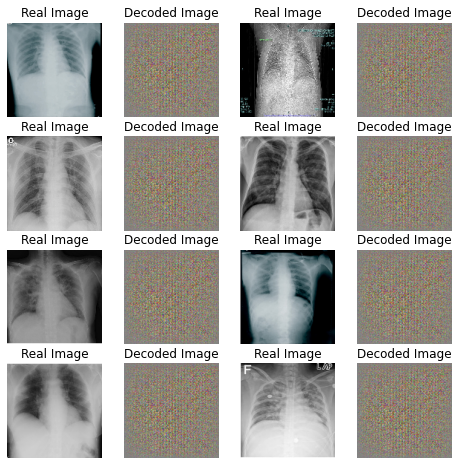

In [25]:
z, mean, logvar = autoencoder.encode(images)
predictions = autoencoder.sample(z)
fig = plt.figure(figsize=(8, 8))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  if i % 2 == 0:
    show_img = tf.keras.preprocessing.image.array_to_img(images[i, :, :, :])
    plt.title('Real Image')
    plt.imshow(show_img)
    plt.axis('off')
  else:
    show_img = tf.keras.preprocessing.image.array_to_img(predictions[i, :, :, :])
    plt.title('Decoded Image')
    plt.imshow(show_img)
    plt.axis(False)

Train the CVA

In [27]:
epochs = 200
images, labels = next(iter(covid_ds))
test_sample = images

Epoch: 200, ELBO: 705.1688842773438, time elapse for current epoch: 28.427213668823242


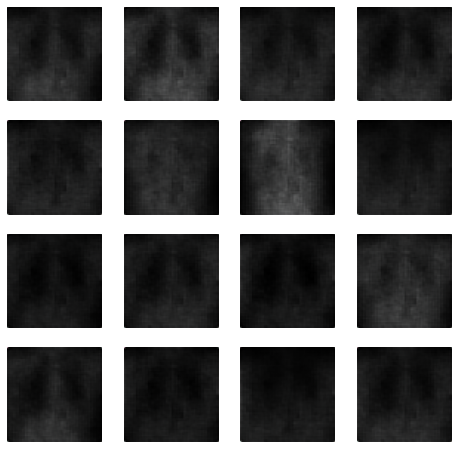

In [29]:
generate_and_save_images(autoencoder, 0, test_sample)
vae_history = dict()
vae_history['loss'] = []
# vae_history['val_loss'] = []

for epoch in range(1, epochs + 1):

  start_time = time.time()
  loss = []
  for train_x, _ in covid_ds:
    temp_loss = train_step(train_x, autoencoder, optimizer)
    loss.append(temp_loss)   

  loss = np.array(loss)
  end_time = time.time()
  elbo = np.mean(loss)
  vae_history['loss'].append(elbo)
  print(f'epoch -- {epoch}: Loss: {elbo}')

  # val_loss = tf.keras.metrics.Mean()
  # for test_x, _ in test_dataset:
  #   val_loss(vae_cost(test_x, autoencoder))
  # val_elbo = -val_loss.result()
  # vae_history['val_loss'].append(val_elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(autoencoder, epoch, test_sample)

In [30]:
autoencoder.encoder.save('CVA_encoder_128')
autoencoder.decoder.save('CVA_decoder_128')
!zip -r CVA_decoder_128.zip CVA_decoder_128
!zip -r CVA_encoder_128.zip CVA_encoder_128

  adding: CVA_decoder_128/ (stored 0%)
  adding: CVA_decoder_128/assets/ (stored 0%)
  adding: CVA_decoder_128/variables/ (stored 0%)
  adding: CVA_decoder_128/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: CVA_decoder_128/variables/variables.index (deflated 57%)
  adding: CVA_decoder_128/keras_metadata.pb (deflated 94%)
  adding: CVA_decoder_128/saved_model.pb (deflated 91%)
  adding: CVA_encoder_128/ (stored 0%)
  adding: CVA_encoder_128/assets/ (stored 0%)
  adding: CVA_encoder_128/variables/ (stored 0%)
  adding: CVA_encoder_128/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: CVA_encoder_128/variables/variables.index (deflated 56%)
  adding: CVA_encoder_128/keras_metadata.pb (deflated 93%)
  adding: CVA_encoder_128/saved_model.pb (deflated 89%)


Text(0.5, 0, 'epoch')

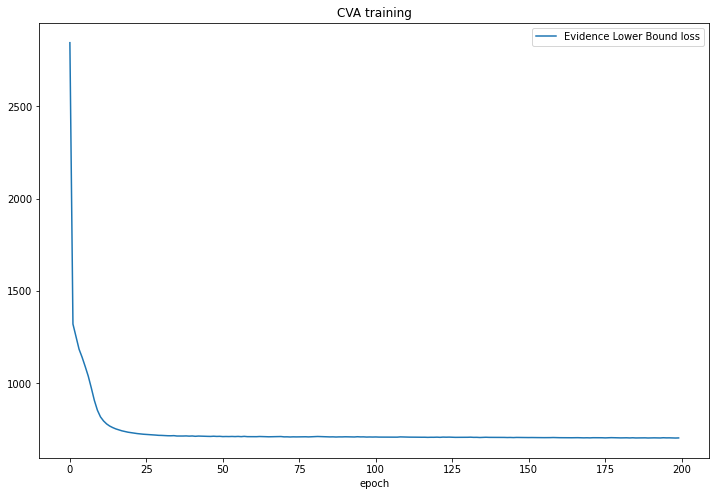

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(vae_history['loss'], label='Evidence Lower Bound loss')
plt.legend(loc='best')
plt.title('CVA training')
plt.xlabel('epoch')